In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cPickle as pickle

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

import logging
from logging import info


import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
RANDOM_SEED = 10000
NN_SEED = 1234
random.seed(RANDOM_SEED)

MAX_TERMS = 10000

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
NN_PARAMETER_SEARCH_PREFIX = "nn_bow_{}_batch_{}_nn_parameter_searches.pkl"

In [7]:
SAMPLE_RATIO = 0.15

In [8]:
root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_bow_parameter_search_extended")

training_file = root_location + "docs_output.json"

classifications_index_file = exports_location + "extended_pv_classifications_index.pkl"
doc_classifications_map_file = exports_location + "extended_pv_doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"

In [9]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_label_data(classifications, doc_ids, doc_classification_map):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    data_labels = []
    for i, doc_id in enumerate(doc_ids):
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        data_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
        #if i % 1000 == 0: info(i)
    data_labels = np.array(data_labels, dtype=np.int8)
    return data_labels

In [10]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [11]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 5.36 s, sys: 264 ms, total: 5.62 s
Wall time: 5.62 s


In [12]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 20,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [13]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

## Training and Validation Loop

In [21]:
classifications = valid_subclasses
classifications_type = "subclasses"

In [24]:
NN_OUTPUT_NEURONS = len(classifications)
# NN_INPUT_NEURONS = DOC2VEC_SIZE

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 30
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 2048

MODEL_VERBOSITY = 1

to_skip = []

load_existing_results = True
save_results = True


first_hidden_layer_sizes = [100,200,500,1000]
# first_hidden_layer_sizes = [1000,2000]
# second_hidden_layer_sizes = [1000,2000,3000,4000]
second_hidden_layer_sizes = [None,500,1000,2000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False, True]
# hidden_dropout_options = [False, True]
input_dropout_options = [False]
hidden_dropout_options = [True]
second_hidden_dropout_options = [False]


np.random.seed(NN_SEED)


# Uncomment for Specific Configuration
NN_RANDOM_SEARCH_BUDGET = 1
first_hidden_layer_sizes = [500]
second_hidden_layer_sizes = [2000]
first_hidden_layer_activations = ['relu']
second_hidden_layer_activations = ['relu']
input_dropout_options = [False]
hidden_dropout_options = [True]
second_hidden_dropout_options = [False]

In [25]:
%matplotlib notebook

2017-04-02 15:26:39,696 : INFO : =============== bm25 Being Evaluated ================
2017-04-02 15:26:39,697 : INFO : Getting Training Data


CPU times: user 1min 42s, sys: 12.4 s, total: 1min 54s
Wall time: 1min 58s


2017-04-02 15:29:55,241 : INFO : Getting Validation Data


CPU times: user 12.9 s, sys: 2.02 s, total: 14.9 s
Wall time: 1min 15s
(254767, 10000)
(254767, 940)
CPU times: user 22.2 s, sys: 448 ms, total: 22.7 s
Wall time: 22.7 s


2017-04-02 15:30:21,034 : INFO : Densifying Matrices


CPU times: user 2.71 s, sys: 260 ms, total: 2.97 s
Wall time: 2.84 s


2017-04-02 15:30:56,746 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_bow_parameter_search/bm25/size_10000/nn_bow_subclasses_batch_2048_nn_parameter_searches.pkl
2017-04-02 15:30:56,931 : INFO : ***************************************************************************************
2017-04-02 15:30:56,933 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           5000500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          1002000     dropout_3[0][0]                  
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


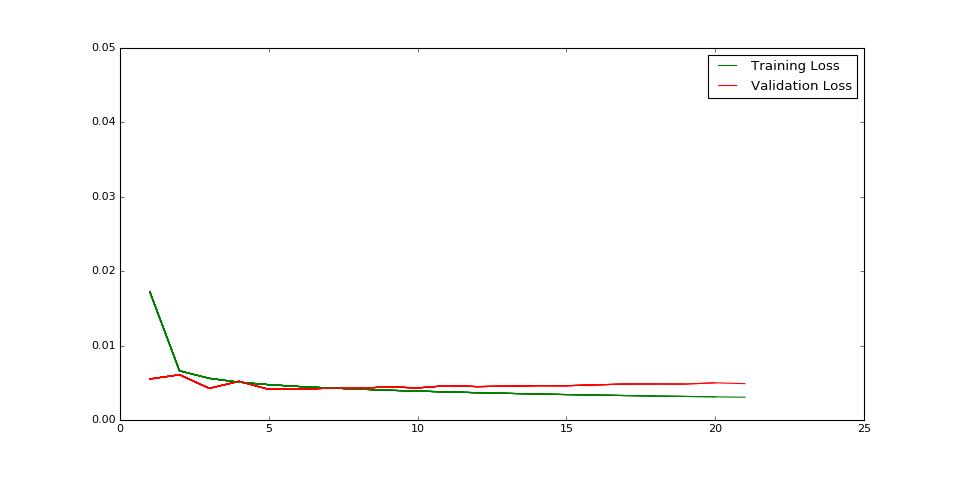

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.0173

2017-04-02 15:31:22,867 : INFO : Found lower val loss for epoch 1 => 0.00552


254767/254767 [==============================] - 21s - loss: 0.0172 - val_loss: 0.0055
Epoch 2/200
254767/254767 [==============================] - 19s - loss: 0.0066 - val_loss: 0.0061
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.0056

2017-04-02 15:32:02,257 : INFO : Found lower val loss for epoch 3 => 0.00426


254767/254767 [==============================] - 19s - loss: 0.0056 - val_loss: 0.0043
Epoch 4/200
254767/254767 [==============================] - 20s - loss: 0.0051 - val_loss: 0.0052
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.0047

2017-04-02 15:32:44,079 : INFO : Found lower val loss for epoch 5 => 0.00412


254767/254767 [==============================] - 20s - loss: 0.0047 - val_loss: 0.0041
Epoch 6/200
254767/254767 [==============================] - 20s - loss: 0.0045 - val_loss: 0.0042
Epoch 7/200
254767/254767 [==============================] - 20s - loss: 0.0043 - val_loss: 0.0043
Epoch 8/200
254767/254767 [==============================] - 20s - loss: 0.0042 - val_loss: 0.0042
Epoch 9/200
254767/254767 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0045
Epoch 10/200
254767/254767 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0043
Epoch 11/200
254767/254767 [==============================] - 22s - loss: 0.0038 - val_loss: 0.0046
Epoch 12/200
254767/254767 [==============================] - 23s - loss: 0.0037 - val_loss: 0.0045
Epoch 13/200
254767/254767 [==============================] - 23s - loss: 0.0036 - val_loss: 0.0045
Epoch 14/200
254767/254767 [==============================] - 23s - loss: 0.0035 - val_loss: 0.0046
Epoch 15/200
2547

2017-04-02 15:38:44,794 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00020: early stopping
CPU times: user 4min 48s, sys: 2min 54s, total: 7min 42s
Wall time: 7min 46s


2017-04-02 15:39:11,821 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.758 | Top 3: 0.688 | Top 5: 0.770 | F1 Micro: 0.526 | F1 Macro: 0.094
CPU times: user 7min 48s, sys: 3min 50s, total: 11min 38s
Wall time: 12min 56s


In [26]:
%%time
data_types = ["bm25"]
# data_types = ["tf"]
for data_type in data_types:
    info("=============== {} Being Evaluated ================".format(data_type))
    
    GLOBAL_VARS.MODEL_NAME = data_type + "/size_{}".format(MAX_TERMS)
     
    data_training_location = exports_location + "extended_pv_benchmarking_data/" + "{}_training_sparse_data.pkl".format(data_type)
    data_training_docids_location = exports_location + "extended_pv_benchmarking_data/" + "{}_training_sparse_docids.pkl".format(data_type)
    data_validation_location = exports_location + "extended_pv_benchmarking_data/" + "{}_validation_sparse_data.pkl".format(data_type)
    data_validation_docids_location = exports_location + "extended_pv_benchmarking_data/" + "{}_validation_sparse_docids.pkl".format(data_type)
    
    # Get the training data
    info('Getting Training Data')
    %time X = pickle.load(open(data_training_location, "r"))
    training_data_docids = pickle.load(open(data_training_docids_location, "r"))
    %time y = get_label_data(classifications, training_data_docids, doc_classification_map)
    
    print X.shape
    print y.shape

    # Get the validation data
    info('Getting Validation Data')
    %time Xv = pickle.load(open(data_validation_location,'r'))
    validation_data_docids = pickle.load(open(data_validation_docids_location, "r"))
    %time yv = get_label_data(classifications, validation_data_docids, doc_classification_map)
    
    # make the matrices dense to feed into keras
    info('Densifying Matrices')
    X = X.todense()
    Xv = Xv.todense()
    
    NN_INPUT_NEURONS = X.shape[1]


    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options,
        'second_hidden_dropout':second_hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

    param_results_dict = {}

    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))

    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results in {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    for parameters in param_sampler:
        start_time = time.time()
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        second_hidden_dropout_do = parameters['second_hidden_dropout']

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )
        if second_hidden_dropout_do:
            GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

        if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
            print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
            continue
    #         if first_hidden_layer_size < DOC2VEC_SIZE or second_hidden_layer_size < NN_OUTPUT_NEURONS:
    #             print "skipping: {} due to 1st layer size {} < {} or 2nd layer size {} < {}".format(GLOBAL_VARS.NN_MODEL_NAME,
    #                                                                                                 first_hidden_layer_size, DOC2VEC_SIZE, 
    #                                                                                                 second_hidden_layer_size, NN_OUTPUT_NEURONS)
    #             continue


        info('***************************************************************************************')
        info(GLOBAL_VARS.NN_MODEL_NAME)

        model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
        model.summary()

        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                      patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
        metrics_callback = MetricsCallback()

        # Model Fitting
        %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                                  nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, callbacks=[early_stopper, metrics_callback])


        # using the recorded weights of the best recorded validation loss
        last_model_weights = model.get_weights()
        info('Evaluating on Validation Data using saved best weights')
        model.set_weights(metrics_callback.best_weights)
        yvp = model.predict(Xv)
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
            validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'])
        best_validation_metrics = validation_metrics
        time.sleep(0.2)

        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

        duration = time.time() - start_time
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

        del history, last_model_weights, metrics_callback

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))
    del X, Xv